In [3]:
import os
from dataclasses import dataclass
from typing import List, Optional, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
df = pd.read_csv("nat_gas.csv")

def to_month_end(ts: pd.Timestamp) -> pd.Timestamp:
    return ts.to_period("M").to_timestamp("M")

def rmse(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def smape(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom == 0, 1.0, denom)
    return float(100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom))


Data snapshot


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17676\3883605719.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17676\3883605719.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range(df.index.min(), df.index.max(), freq="M")


,Price
Date,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


,Price
Date,
2024-05-31,11.4
2024-06-30,11.5
2024-07-31,11.6
2024-08-31,11.5
2024-09-30,11.8



Basic stats


count    48.000000
mean     11.207083
std       0.757897
min       9.840000
25%      10.650000
50%      11.300000
75%      11.625000
max      12.800000
Name: Price, dtype: float64

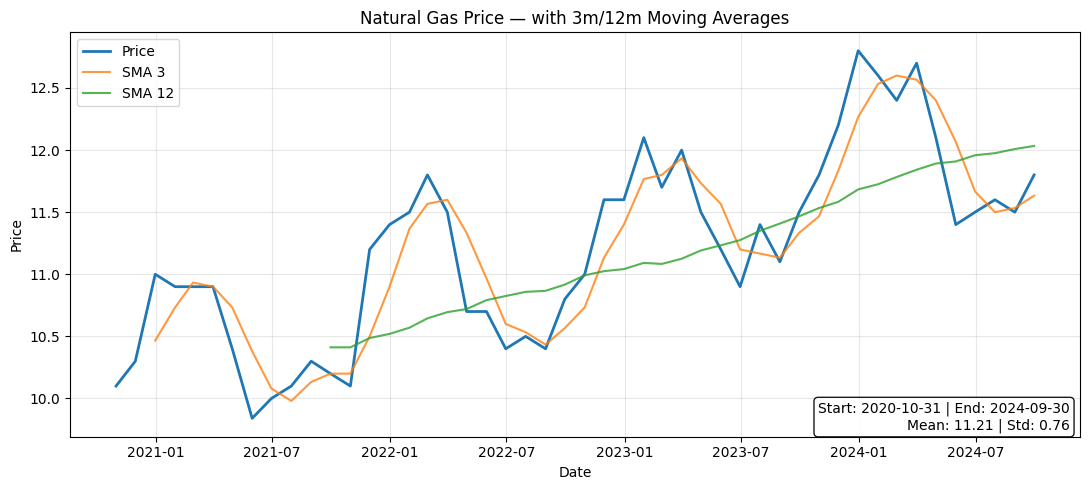

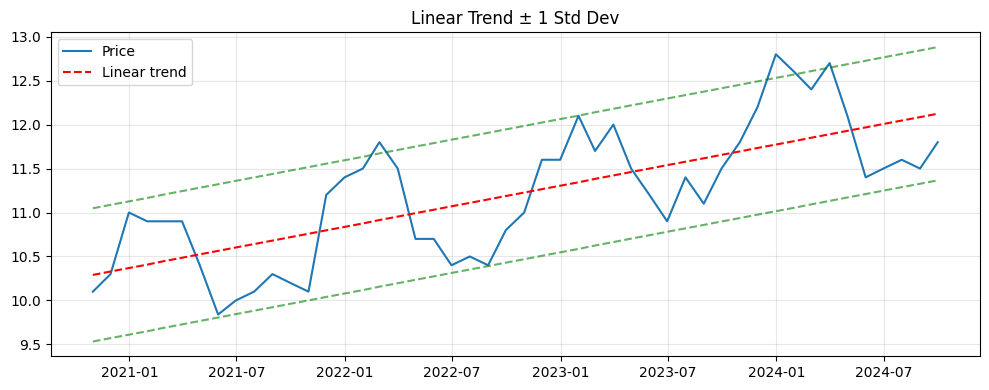

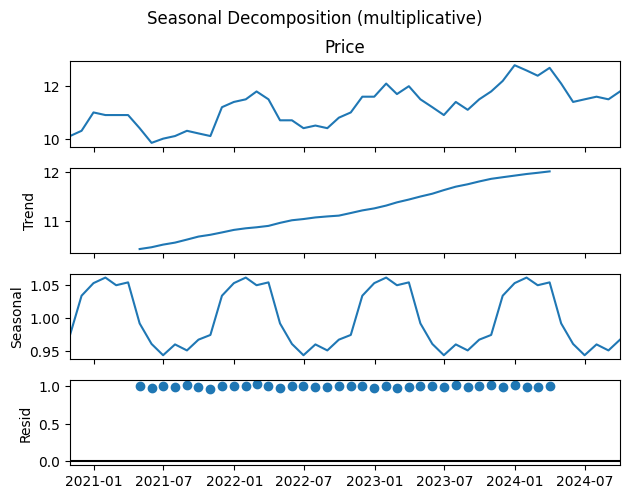

In [6]:
# %% Load & clean data, quick EDA (like your Approach 2 visuals)
raw = pd.read_csv("Nat_Gas.csv")

cols = {c.lower(): c for c in raw.columns}
date_col = cols.get("dates") or cols.get("date")
price_col = cols.get("prices") or cols.get("price")
if not date_col or not price_col:
    raise ValueError("CSV must have 'Dates' and 'Prices' columns (any case).")

df = raw[[date_col, price_col]].copy()
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col])
df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
df = df.dropna(subset=[price_col])

df["Date"] = df[date_col].apply(to_month_end)
df = df.groupby("Date", as_index=True)[price_col].mean().to_frame("Price").sort_index()

# reindex to contiguous monthly EOM; fill small gaps
idx = pd.date_range(df.index.min(), df.index.max(), freq="M")
df = df.reindex(idx)
df["Price"] = df["Price"].interpolate("time").bfill().ffill()
df.index.name = "Date"

print("\nData snapshot")
display(df.head())
display(df.tail())

print("\nBasic stats")
display(df["Price"].describe())

# Rolling averages (Approach 2 vibe)
df["SMA_3"] = df["Price"].rolling(3).mean()
df["SMA_12"] = df["Price"].rolling(12).mean()

fig, ax = plt.subplots(figsize=(11,5))
ax.plot(df.index, df["Price"], label="Price", linewidth=2)
ax.plot(df.index, df["SMA_3"], label="SMA 3", alpha=0.8)
ax.plot(df.index, df["SMA_12"], label="SMA 12", alpha=0.8)
ax.set_title("Natural Gas Price — with 3m/12m Moving Averages")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.grid(alpha=0.3); ax.legend(loc="upper left")

# Small text box
box = (f"Start: {df.index.min().date()} | End: {df.index.max().date()}\n"
       f"Mean: {df['Price'].mean():.2f} | Std: {df['Price'].std():.2f}")
ax.text(0.99, 0.01, box, transform=ax.transAxes, ha="right", va="bottom",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
plt.tight_layout(); plt.show()

# Simple linear trend and +/- 1 std band (Approach 2)
time = np.arange(len(df))  # months since start
coef = np.polyfit(time, df["Price"].values, 1)
trend = np.polyval(coef, time)
std = df["Price"].std()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df.index, df["Price"].values, label="Price")
ax.plot(df.index, trend, "r--", label="Linear trend")
ax.plot(df.index, trend - std, "g--", alpha=0.6)
ax.plot(df.index, trend + std, "g--", alpha=0.6)
ax.set_title("Linear Trend ± 1 Std Dev")
ax.grid(alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

# Seasonal decomposition (Approach 2)
try:
    decomp = seasonal_decompose(df["Price"], model="multiplicative", period=12)
    decomp.plot(); plt.suptitle("Seasonal Decomposition (multiplicative)", y=1.03)
    plt.show()
except Exception as e:
    print("Decomposition note:", e)


Fitting OLS: Price = β0 + β1*t + month dummies ...


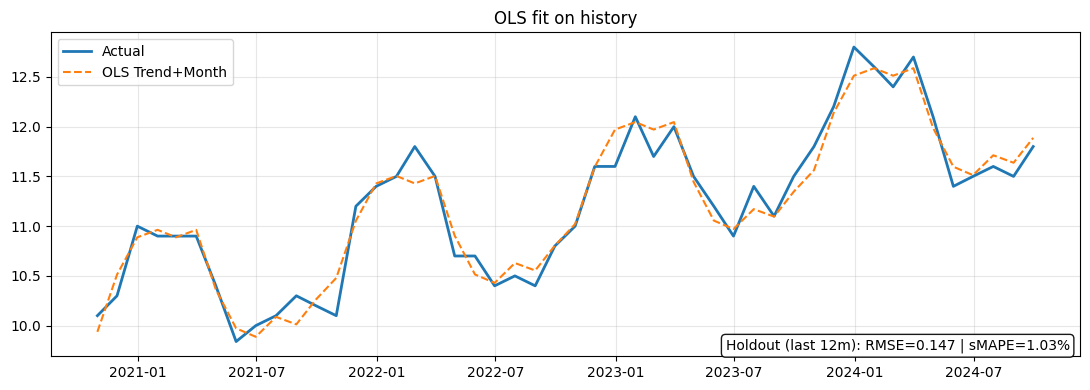

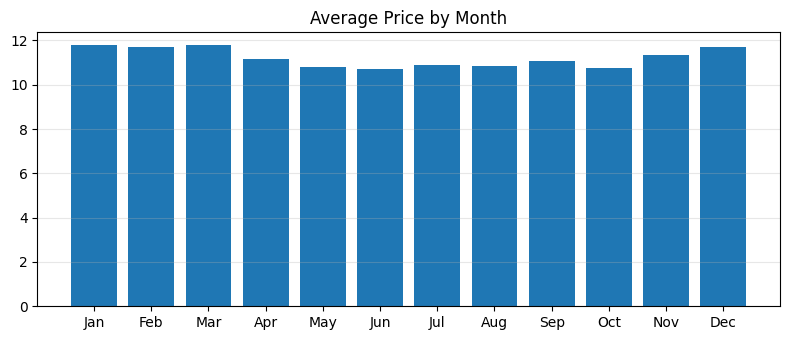

In [7]:
# %% OLS: Trend + Month-of-Year
print("Fitting OLS: Price = β0 + β1*t + month dummies ...")

first = df.index.min().to_period("M")
per = df.index.to_period("M")
X = pd.DataFrame(index=df.index)
X["t"] = (per.year - first.year)*12 + (per.month - first.month)
X["month"] = df.index.month
X = pd.get_dummies(X, columns=["month"], drop_first=True)
y = df["Price"].values

lr = LinearRegression().fit(X, y)
ols_fit = lr.predict(X)

# Backtest: last 12 months
n_test = min(12, len(df))
y_test = y[-n_test:]
ols_test = ols_fit[-n_test:]
ols_rmse, ols_smape = rmse(y_test, ols_test), smape(y_test, ols_test)

fig, ax = plt.subplots(figsize=(11,4))
ax.plot(df.index, df["Price"], label="Actual", linewidth=2)
ax.plot(df.index, ols_fit, "--", label="OLS Trend+Month")
ax.set_title("OLS fit on history")
ax.grid(alpha=0.3); ax.legend(loc="upper left")
ax.text(0.99, 0.01, f"Holdout (last {n_test}m): RMSE={ols_rmse:.3f} | sMAPE={ols_smape:.2f}%",
        transform=ax.transAxes, ha="right", va="bottom",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
plt.tight_layout(); plt.show()

# Avg price by month (seasonality bars)
month_avg = df.groupby(df.index.month)["Price"].mean()
fig, ax = plt.subplots(figsize=(8,3.5))
ax.bar(range(1,13), month_avg.values)
ax.set_xticks(range(1,13)); ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
ax.set_title("Average Price by Month")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()


Fitting SARIMA (2,1,2) x (0,1,1,12) ...


c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


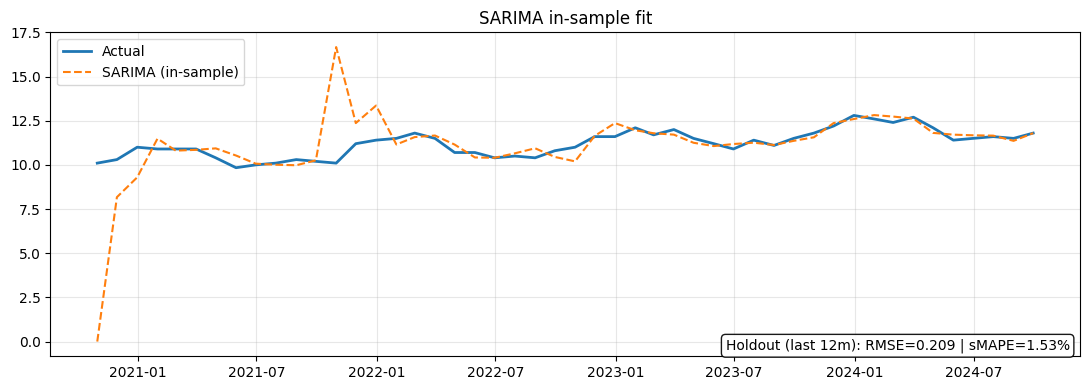

In [8]:
# %% SARIMA (keep it pragmatic & explainable)
print("Fitting SARIMA (2,1,2) x (0,1,1,12) ...")
sar_model = SARIMAX(df["Price"], order=(2,1,2), seasonal_order=(0,1,1,12),
                    enforce_stationarity=False, enforce_invertibility=False)
sar_res = sar_model.fit(disp=False)
sar_hist_fit = sar_res.fittedvalues.reindex(df.index)

# Holdout performance: last 12 months using one-step-ahead preds where possible
n_test = min(12, len(df))
y_test = df["Price"].values[-n_test:]
sar_test = sar_hist_fit.values[-n_test:]
sar_rmse, sar_smape = rmse(y_test, sar_test), smape(y_test, sar_test)

fig, ax = plt.subplots(figsize=(11,4))
ax.plot(df.index, df["Price"], label="Actual", linewidth=2)
ax.plot(df.index, sar_hist_fit, "--", label="SARIMA (in-sample)")
ax.set_title("SARIMA in-sample fit")
ax.grid(alpha=0.3); ax.legend(loc="upper left")
ax.text(0.99, 0.01, f"Holdout (last {n_test}m): RMSE={sar_rmse:.3f} | sMAPE={sar_smape:.2f}%",
        transform=ax.transAxes, ha="right", va="bottom",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
plt.tight_layout(); plt.show()


10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing


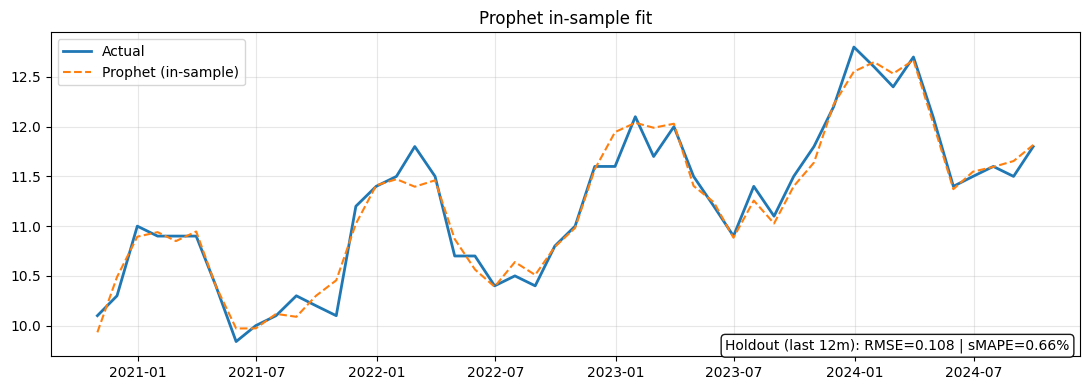

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17676\1767038592.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range(df.index.max() + pd.offsets.MonthEnd(1), periods=h, freq="M")


✅ Built monthly nodes for OLS, SARIMA and Prophet.


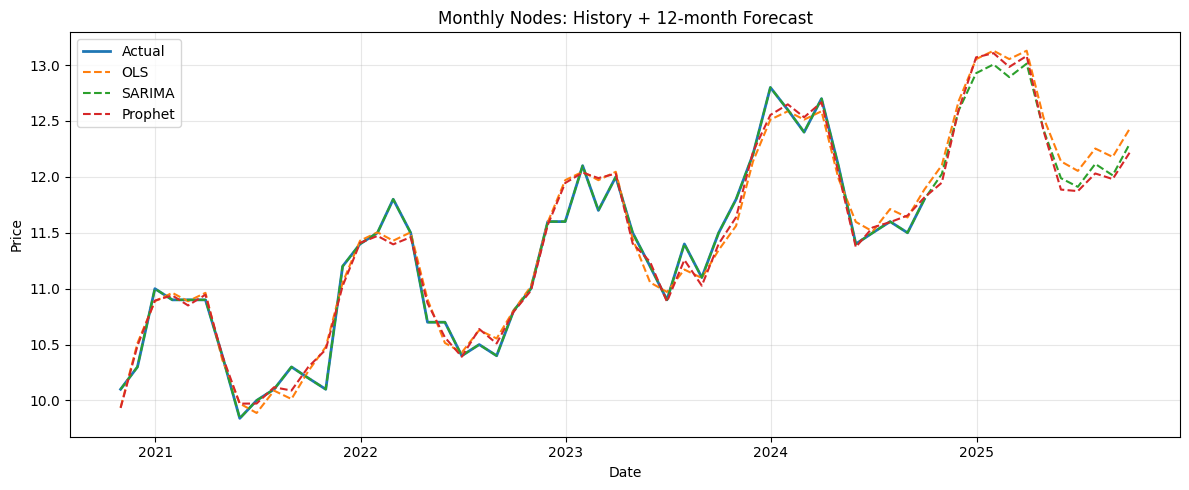

In [14]:
from prophet import Prophet  

pdf = df.reset_index().rename(columns={"Date":"ds","Price":"y"})
m = Prophet(seasonality_mode="multiplicative", yearly_seasonality=True)
m.fit(pdf)
fcst = m.predict(pdf[["ds"]])
prop_hist = fcst.set_index("ds")["yhat"].reindex(df.index)
# backtest
n_test = min(12, len(df))
prop_rmse = rmse(df["Price"].values[-n_test:], prop_hist.values[-n_test:])
prop_smape = smape(df["Price"].values[-n_test:], prop_hist.values[-n_test:])

fig, ax = plt.subplots(figsize=(11,4))
ax.plot(df.index, df["Price"], label="Actual", linewidth=2)
ax.plot(df.index, prop_hist, "--", label="Prophet (in-sample)")
ax.set_title("Prophet in-sample fit")
ax.grid(alpha=0.3); ax.legend(loc="upper left")
ax.text(0.99, 0.01, f"Holdout (last {n_test}m): RMSE={prop_rmse:.3f} | sMAPE={prop_smape:.2f}%",
        transform=ax.transAxes, ha="right", va="bottom",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
plt.tight_layout(); plt.show()

# %% Forecast each model 12 months ahead; build monthly nodes
h = 12
future_idx = pd.date_range(df.index.max() + pd.offsets.MonthEnd(1), periods=h, freq="M")

# OLS forecast
X_all = X.copy()
X_future = X.iloc[[-1]].copy()
# build future rows properly
future_X = []
for k, dt in enumerate(future_idx, start=1):
    row = {}
    row["t"] = X_all["t"].iloc[-1] + k
    # month dummies
    month = dt.month
    for col in X_all.columns:
        if col.startswith("month_"):
            row[col] = 1 if int(col.split("_")[-1]) == month else 0
    # ensure columns
    future_X.append(row)
X_future = pd.DataFrame(future_X, index=future_idx).reindex(columns=X_all.columns).fillna(0)
ols_fore = lr.predict(X_future)

nodes_ols = pd.concat([
    pd.Series(ols_fit, index=df.index),
    pd.Series(ols_fore, index=future_idx)
]).rename("OLS")

# SARIMA forecast
sar_fore = sar_res.get_forecast(steps=h).predicted_mean
nodes_sar = pd.concat([
    df["Price"],
    pd.Series(sar_fore, index=future_idx)
]).rename("SARIMA")

# Prophet forecast (always do it)
future = pd.DataFrame({"ds": future_idx})
pf = m.predict(future)
prop_fore = pf.set_index("ds")["yhat"].reindex(future_idx)
nodes_prop = pd.concat([prop_hist, prop_fore]).rename("Prophet")

print("✅ Built monthly nodes for OLS, SARIMA and Prophet.")

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df.index, df["Price"], label="Actual", linewidth=2)
ax.plot(nodes_ols.index, nodes_ols.values, "--", label="OLS")
ax.plot(nodes_sar.index, nodes_sar.values, "--", label="SARIMA")
ax.plot(nodes_prop.index, nodes_prop.values, "--", label="Prophet")
ax.set_title("Monthly Nodes: History + 12-month Forecast")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.grid(alpha=0.3); ax.legend(loc="upper left")
plt.tight_layout(); plt.show()


🧪 Holdout (last 12m) metrics & weights
  OLS      → RMSE=0.547 | sMAPE=4.32% | weight=0.23
  SARIMA   → RMSE=0.420 | sMAPE=3.30% | weight=0.38
  Prophet  → RMSE=0.414 | sMAPE=3.27% | weight=0.39


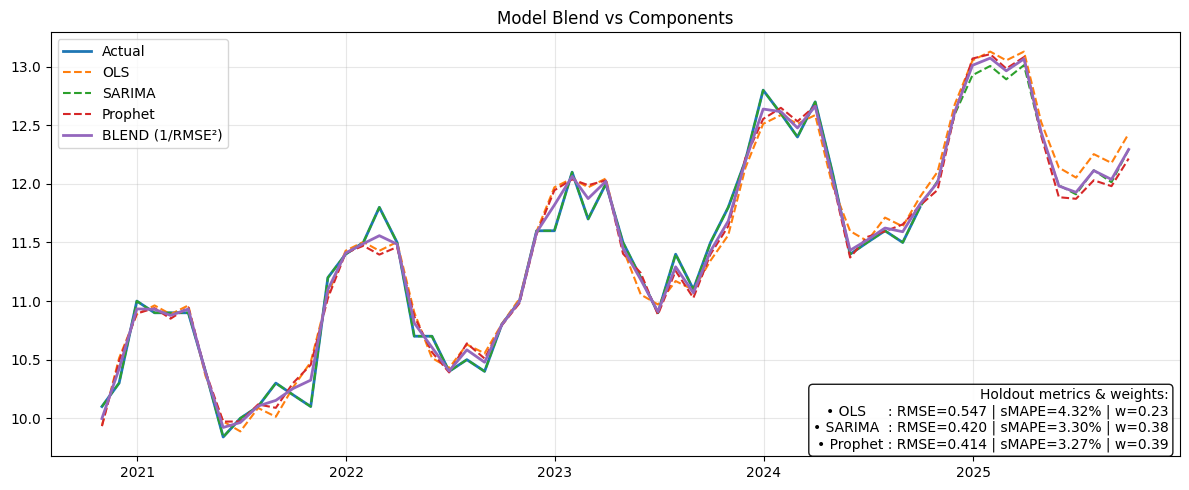

In [15]:
# %% Blend models with weights ∝ 1/RMSE² (lower error => higher weight)
metrics = {
    "OLS":  {"rmse": rmse(df["Price"].values[-12:], nodes_ols.values[-12:]),
             "smape": smape(df["Price"].values[-12:], nodes_ols.values[-12:])},
    "SARIMA":{"rmse": rmse(df["Price"].values[-12:], nodes_sar.values[-12:]),
              "smape": smape(df["Price"].values[-12:], nodes_sar.values[-12:])},
}
if nodes_prop is not None:
    metrics["Prophet"] = {"rmse": rmse(df["Price"].values[-12:], nodes_prop.values[-12:]),
                          "smape": smape(df["Price"].values[-12:], nodes_prop.values[-12:])}

inv_mse = {k: 1.0 / (max(1e-6, m["rmse"])**2) for k, m in metrics.items()}
wsum = sum(inv_mse.values())
weights = {k: v/wsum for k, v in inv_mse.items()}

# Blend all nodes where available
blend = None
for name, series in [("OLS", nodes_ols), ("SARIMA", nodes_sar), ("Prophet", nodes_prop)]:
    if series is None: 
        continue
    w = weights.get(name, 0.0)
    blend = series.mul(w) if blend is None else blend.add(series.mul(w), fill_value=0.0)
nodes_blend = blend.rename("Blend")

print("🧪 Holdout (last 12m) metrics & weights")
for k, m in metrics.items():
    print(f"  {k:8s} → RMSE={m['rmse']:.3f} | sMAPE={m['smape']:.2f}% | weight={weights.get(k,0):.2f}")

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df.index, df["Price"], label="Actual", linewidth=2)
ax.plot(nodes_ols.index, nodes_ols, "--", label="OLS")
ax.plot(nodes_sar.index, nodes_sar, "--", label="SARIMA")
if nodes_prop is not None:
    ax.plot(nodes_prop.index, nodes_prop, "--", label="Prophet")
ax.plot(nodes_blend.index, nodes_blend, "-", label="BLEND (1/RMSE²)", linewidth=2)

ax.set_title("Model Blend vs Components")
ax.grid(alpha=0.3); ax.legend(loc="upper left")

# Text panel
panel = "Holdout metrics & weights:\n" + "\n".join(
    [f"• {k:8s}: RMSE={v['rmse']:.3f} | sMAPE={v['smape']:.2f}% | w={weights.get(k,0):.2f}" for k,v in metrics.items()]
)
ax.text(0.99, 0.01, panel, transform=ax.transAxes, ha="right", va="bottom",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
plt.tight_layout(); plt.show()


In [16]:
# %% Calendar-date price function (interpolates between monthly nodes)
def blended_price(date_like) -> float:
    dt = pd.to_datetime(date_like)
    if dt <= nodes_blend.index.min():
        return float(nodes_blend.iloc[0])
    if dt >= nodes_blend.index.max():
        return float(nodes_blend.iloc[-1])
    pos = nodes_blend.index.searchsorted(dt)
    t0, t1 = nodes_blend.index[pos-1], nodes_blend.index[pos]
    p0, p1 = float(nodes_blend.loc[t0]), float(nodes_blend.loc[t1])
    frac = (dt - t0) / (t1 - t0)
    return float(p0 + frac*(p1 - p0))

print("🧪 Spot checks:")
for d in ["2022-02-15","2024-11-30","2025-03-10"]:
    print(f"  Price @ {d}: ${blended_price(d):.3f}")


🧪 Spot checks:
  Price @ 2022-02-15: $11.526
  Price @ 2024-11-30: $12.616
  Price @ 2025-03-10: $12.997


In [ ]:
# %% Storage Contract Pricer (capacity/rate/fees) + visuals

@dataclass
class ContractParams:
    injection_dates: List[str]
    injection_volumes_mmbtu: List[float]
    withdrawal_dates: List[str]
    withdrawal_volumes_mmbtu: List[float]

    max_storage_mmbtu: float
    injection_rate_mmbtu_per_day: float
    withdrawal_rate_mmbtu_per_day: float

    storage_cost_per_mmbtu_per_month: float
    storage_fixed_fee_per_month: float = 0.0

    injection_cost_per_mmbtu: float = 0.0
    withdrawal_cost_per_mmbtu: float = 0.0
    injection_fixed_fee: float = 0.0
    withdrawal_fixed_fee: float = 0.0
    transport_fee_per_move: float = 0.0

def _expand_events(params: ContractParams) -> pd.DataFrame:
    ev = []
    for d, v in zip(params.injection_dates, params.injection_volumes_mmbtu):
        ev.append(dict(date=pd.to_datetime(d), kind="inject", request=v))
    for d, v in zip(params.withdrawal_dates, params.withdrawal_volumes_mmbtu):
        ev.append(dict(date=pd.to_datetime(d), kind="withdraw", request=v))
    return pd.DataFrame(ev).sort_values("date").reset_index(drop=True)

def price_contract(params: ContractParams, plot=True) -> Dict:
    events = _expand_events(params)
    start = events["date"].min().normalize()
    end = (events["date"].max() + pd.Timedelta(days=30)).normalize()  # give some runway

    days = pd.date_range(start, end, freq="D")
    inv = 0.0
    ledger = []
    # per-event state
    states = []
    for i, row in events.iterrows():
        states.append({
            "kind": row["kind"], "start": row["date"].normalize(),
            "remaining": float(row["request"]), "fixed_charged": False
        })

    for day in days:
        price_today = blended_price(day)

        # injections first
        inj_capacity_left = params.max_storage_mmbtu - inv
        for st in states:
            if st["kind"] != "inject" or day < st["start"] or st["remaining"] <= 0:
                continue
            if inj_capacity_left <= 0:
                break
            vol = min(params.injection_rate_mmbtu_per_day, st["remaining"], inj_capacity_left)
            if vol > 0:
                cash = -(vol * price_today) - (vol * params.injection_cost_per_mmbtu)
                if not st["fixed_charged"]:
                    cash -= (params.injection_fixed_fee + params.transport_fee_per_move)
                    st["fixed_charged"] = True
                ledger.append([day, "Injection", vol, price_today, cash])
                inv += vol
                inj_capacity_left -= vol
                st["remaining"] -= vol

        # withdrawals next
        for st in states:
            if st["kind"] != "withdraw" or day < st["start"] or st["remaining"] <= 0:
                continue
            if inv <= 0:
                break
            vol = min(params.withdrawal_rate_mmbtu_per_day, st["remaining"], inv)
            if vol > 0:
                cash = +(vol * price_today) - (vol * params.withdrawal_cost_per_mmbtu)
                if not st["fixed_charged"]:
                    cash -= (params.withdrawal_fixed_fee + params.transport_fee_per_move)
                    st["fixed_charged"] = True
                ledger.append([day, "Withdrawal", -vol, price_today, cash])
                inv -= vol
                st["remaining"] -= vol

        # inventory snapshot
        ledger.append([day, "Inventory", inv, np.nan, 0.0])

    ledger = pd.DataFrame(ledger, columns=["date","action","volume","price","cash"])

    # monthly storage fees (variable on avg inventory + fixed)
    inv_daily = ledger[ledger["action"]=="Inventory"][["date","volume"]].set_index("date")["volume"]
    mgrp = inv_daily.groupby(inv_daily.index.to_period("M"))
    storage_lines = []
    for per, series in mgrp:
        avg_inv = float(series.mean())
        fee = -(avg_inv * params.storage_cost_per_mmbtu_per_month + params.storage_fixed_fee_per_month)
        if fee != 0:
            storage_lines.append([per.to_timestamp("M"), "StorageFee", 0.0, np.nan, fee])

    if storage_lines:
        storage_df = pd.DataFrame(storage_lines, columns=["date","action","volume","price","cash"])
        ledger = pd.concat([ledger, storage_df], ignore_index=True).sort_values("date")

    # summary
    inj_cost = -ledger[ledger["action"]=="Injection"]["cash"].sum()
    with_rev = ledger[ledger["action"]=="Withdrawal"]["cash"].sum()
    storage_cost = -ledger[ledger["action"]=="StorageFee"]["cash"].sum() if "StorageFee" in ledger["action"].values else 0.0
    contract_value = ledger["cash"].sum()

    unfinished = []
    for st in states:
        if st["remaining"] > 1e-9:
            unfinished.append((st["kind"], st["remaining"], st["start"].date()))

    summary = dict(
        contract_value=contract_value,
        total_injection_cost=inj_cost,
        total_withdrawal_revenue=with_rev,
        total_storage_cost=storage_cost,
        unfinished=unfinished
    )

    if plot:
        # Inventory plot with text summary
        fig, ax = plt.subplots(figsize=(12,4))
        inv_series = ledger[ledger["action"]=="Inventory"][["date","volume"]]
        ax.plot(inv_series["date"], inv_series["volume"], linewidth=2)
        ax.set_title("Inventory Over Time (MMBtu)")
        ax.set_xlabel("Date"); ax.set_ylabel("MMBtu"); ax.grid(alpha=0.3)
        panel = (f"Contract Value:  ${contract_value:,.0f}\n"
                 f"Withdrawal Rev:  ${with_rev:,.0f}\n"
                 f"Injection Cost:  ${inj_cost:,.0f}\n"
                 f"Storage Cost:    ${storage_cost:,.0f}")
        ax.text(0.99, 0.01, panel, transform=ax.transAxes, ha="right", va="bottom",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
        plt.tight_layout(); plt.show()

        # Cash flow stem plot
        cf = ledger[ledger["action"].isin(["Injection","Withdrawal","StorageFee"])].copy()
        fig, ax = plt.subplots(figsize=(12,4))
        ax.stem(cf["date"], cf["cash"], basefmt=" ")
        ax.axhline(0, color="black", linewidth=1)
        ax.set_title("Cash Flows Over Time  (positive = cash in)")
        ax.set_xlabel("Date"); ax.set_ylabel("USD"); ax.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

    # human readout
    print("\n-----------------------------------------------")
    print("Storage Contract — quick readout")
    print("-----------------------------------------------")
    print(f"Contract value (NPV @ 0%): ${contract_value:,.0f}")
    print(f"   Withdrawal revenue     : ${with_rev:,.0f}")
    print(f"   Injection cost         : ${inj_cost:,.0f}")
    print(f"   Storage fees           : ${storage_cost:,.0f}")
    if unfinished:
        for k, rem, start in unfinished:
            print(f"⚠️  Unfinished {k} of {rem:,.0f} MMBtu (started {start}) — rate/capacity constraint")
    else:
        print("All scheduled volumes executed within constraints.")
    print("-----------------------------------------------")

    return dict(ledger=ledger, **summary)


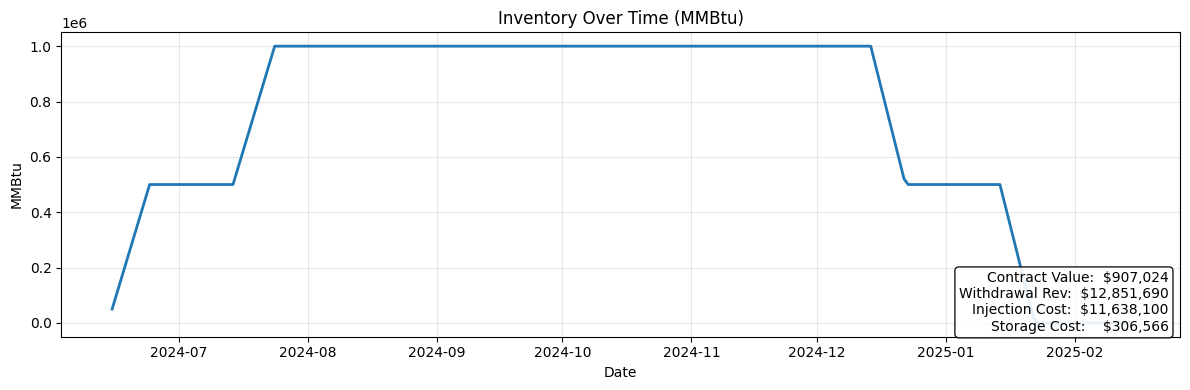

TypeError: Axes.stem() got an unexpected keyword argument 'use_line_collection'

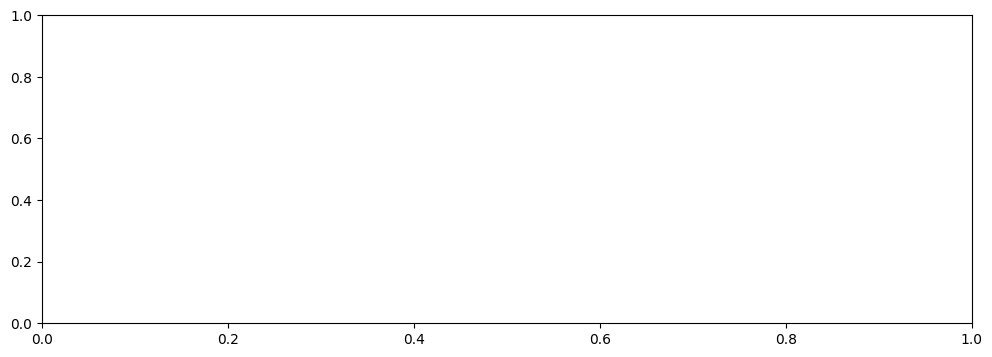

In [18]:
# %% Demo: price a simple Summer→Winter storage idea
params = ContractParams(
    injection_dates=["2024-06-15","2024-07-15"],
    injection_volumes_mmbtu=[500_000, 500_000],

    withdrawal_dates=["2024-12-15","2025-01-15"],
    withdrawal_volumes_mmbtu=[500_000, 500_000],

    max_storage_mmbtu=2_000_000,
    injection_rate_mmbtu_per_day=50_000,
    withdrawal_rate_mmbtu_per_day=60_000,

    storage_cost_per_mmbtu_per_month=0.05,  # variable monthly fee
    storage_fixed_fee_per_month=0.00,        # set >0 if there is a fixed lease

    injection_cost_per_mmbtu=0.10,
    withdrawal_cost_per_mmbtu=0.10,
    injection_fixed_fee=0.00,                # e.g., 50_000 per injection
    withdrawal_fixed_fee=0.00,               # e.g., 50_000 per withdrawal
    transport_fee_per_move=0.00              # e.g., 100_000 each move
)

result = price_contract(params, plot=True)

print("\n🧪 Extra spot-checks on the pricing function:")
for d in ["2024-07-01","2024-12-20","2025-03-10"]:
    print(f"  Price @ {d}: ${blended_price(d):.3f}")
